In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import scipy.sparse as sp
from torch.utils.data import Dataset, DataLoader

# Load dataset
df = pd.read_csv(r"C:\Users\hp\Desktop\Last Hope\cleaned_engagement_data3.csv")


# Encode UserID and CourseID
df['user_id_idx'] = df['UserID'].astype('category').cat.codes
df['item_id_idx'] = df['CourseID'].astype('category').cat.codes

n_users = df['user_id_idx'].nunique()
n_items = df['item_id_idx'].nunique()

c:\Users\hp\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [ ]:
# Rebuild the model architecture
n_users = 8123  
n_items = 7  


In [ ]:
class LightGCN(nn.Module):
    def __init__(self, data, n_users, n_items, n_layers=3, latent_dim=128, dropout=0.4, weight_decay=1e-4):
        super(LightGCN, self).__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.n_layers = n_layers
        self.latent_dim = latent_dim
        self.weight_decay = weight_decay
        self.dropout = nn.Dropout(p=dropout)   

        # Initialize embeddings
        self.user_embedding = nn.Embedding(n_users, latent_dim)
        self.item_embedding = nn.Embedding(n_items, latent_dim)
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)

        # Create adjacency matrix
        self.norm_adj_mat_sparse_tensor = self.get_A_tilda(data)

    def get_A_tilda(self, data):
        R = sp.dok_matrix((self.n_users, self.n_items), dtype=np.float32)
        
        for _, row in data.iterrows():
            user_idx = int(row['user_id_idx'])   
            item_idx = int(row['item_id_idx'])  
            R[user_idx, item_idx] = 1.0   
        
        adj_mat = sp.dok_matrix((self.n_users + self.n_items, self.n_users + self.n_items), dtype=np.float32).tolil()
        R = R.tolil()
        adj_mat[:self.n_users, self.n_users:] = R
        adj_mat[self.n_users:, :self.n_users] = R.T

        # Normalize adjacency matrix
        rowsum = np.array(adj_mat.sum(1))
        d_inv = np.power(rowsum, -0.5).flatten()
        d_inv[np.isinf(d_inv)] = 0.0
        D_inv = sp.diags(d_inv)
        norm_adj_mat = D_inv @ adj_mat @ D_inv

        return torch.FloatTensor(norm_adj_mat.toarray())


    def forward(self, users, pos_items, neg_items):
        user_emb = self.user_embedding(users)
        pos_emb = self.item_embedding(pos_items)
        neg_emb = self.item_embedding(neg_items)

        # Regularization term for L2 weight decay
        l2_reg = (user_emb.norm(2).pow(2) + pos_emb.norm(2).pow(2) + neg_emb.norm(2).pow(2)) / 3

        return user_emb, pos_emb, neg_emb, l2_reg


In [ ]:
import torch

def compute_metrics(users_emb, pos_emb, neg_emb, k=7):
    pos_scores = (users_emb * pos_emb).sum(dim=1)
    neg_scores = (users_emb * neg_emb).sum(dim=1)

    # Compute ranking
    combined_scores = torch.cat([pos_scores.unsqueeze(1), neg_scores.unsqueeze(1)], dim=1)
    sorted_indices = torch.argsort(combined_scores, descending=True)

    # Compute Precision@k
    hits = (sorted_indices[:, 0] == 0).float()   
    precision = hits.mean().item()

    # Compute Recall@k  
    recall = precision

    # Compute NDCG@k
    ideal_dcg = (1.0 / torch.log2(torch.arange(2, k + 2).float())).sum().item()
    dcg = (hits / torch.log2(torch.arange(2, hits.shape[0] + 2).float())).sum().item()
    ndcg = (dcg / ideal_dcg) if ideal_dcg > 0 else 0.0

    # Compute MAP@k
    ap = (hits.cumsum(dim=0) / torch.arange(1, hits.shape[0] + 1).float()).mean().item()

    print(f"Precision@{k}: {precision:.4f}, Recall@{k}: {recall:.4f}, NDCG@{k}: {ndcg:.4f}, MAP@{k}: {ap:.4f}")


In [8]:
# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightGCN(df, n_users, n_items).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.BCEWithLogitsLoss()

# Prepare dataset for training
interaction_matrix = df.groupby("user_id_idx")["item_id_idx"].apply(list).to_dict()

# Training
num_epochs = 30
batch_size = 100

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    users = torch.randint(0, n_users, (batch_size,)).to(device)
    pos_items = torch.tensor([np.random.choice(interaction_matrix[u.item()]) for u in users], dtype=torch.long).to(device)
    neg_items = torch.randint(0, n_items, (batch_size,)).to(device)

    users_emb, pos_emb, neg_emb, l2_reg = model(users, pos_items, neg_items)

    # Bayesian Personalized Ranking (BPR) Loss
    loss = -torch.log(torch.sigmoid((users_emb * pos_emb).sum(dim=1) - (users_emb * neg_emb).sum(dim=1))).mean() + l2_reg
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")

    # Evaluate every 5 epochs
    if (epoch + 1) % 5 == 0:
        model.eval()
        with torch.no_grad():
            compute_metrics(users_emb, pos_emb, neg_emb, k=7)

Epoch 1/30, Loss: 117.1379
Epoch 2/30, Loss: 117.4737
Epoch 3/30, Loss: 116.1705
Epoch 4/30, Loss: 113.2948
Epoch 5/30, Loss: 112.3291
Precision@7: 0.5600, Recall@7: 0.5600, NDCG@7: 3.1124, MAP@7: 0.5353
Epoch 6/30, Loss: 109.0253
Epoch 7/30, Loss: 109.0304
Epoch 8/30, Loss: 107.3487
Epoch 9/30, Loss: 106.0433
Epoch 10/30, Loss: 103.4100
Precision@7: 0.6200, Recall@7: 0.6200, NDCG@7: 3.4579, MAP@7: 0.5884
Epoch 11/30, Loss: 103.4523
Epoch 12/30, Loss: 101.5759
Epoch 13/30, Loss: 99.7959
Epoch 14/30, Loss: 97.7329
Epoch 15/30, Loss: 97.2008
Precision@7: 0.5500, Recall@7: 0.5500, NDCG@7: 3.0936, MAP@7: 0.5399
Epoch 16/30, Loss: 95.2572
Epoch 17/30, Loss: 94.2780
Epoch 18/30, Loss: 92.2452
Epoch 19/30, Loss: 91.9371
Epoch 20/30, Loss: 89.4229
Precision@7: 0.6600, Recall@7: 0.6600, NDCG@7: 3.8688, MAP@7: 0.6668
Epoch 21/30, Loss: 88.7328
Epoch 22/30, Loss: 86.5842
Epoch 23/30, Loss: 85.4306
Epoch 24/30, Loss: 84.2447
Epoch 25/30, Loss: 83.0046
Precision@7: 0.6200, Recall@7: 0.6200, NDCG@7:

In [9]:
import tensorflow as tf

import torch

# Save model state dictionary
torch.save(model.state_dict(), "lightgcn_model.pth")



In [10]:
import torch
import numpy as np

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LightGCN(df, n_users=8123, n_items=7).to(device)
model.load_state_dict(torch.load("lightgcn_model.pth"))
model.eval()

# Prepare interaction matrix
interaction_matrix = df.groupby("user_id_idx")["item_id_idx"].apply(list).to_dict()

# Generate evaluation data
batch_size = 100
users = torch.randint(0, n_users, (batch_size,)).to(device)
pos_items = torch.tensor([np.random.choice(interaction_matrix[u.item()]) for u in users], dtype=torch.long).to(device)
neg_items = torch.randint(0, n_items, (batch_size,)).to(device)

# Get embeddings
with torch.no_grad():
    users_emb, pos_emb, neg_emb, _ = model(users, pos_items, neg_items)

# Print metrics
compute_metrics(users_emb, pos_emb, neg_emb, k=7)

Precision@7: 0.5400, Recall@7: 0.5400, NDCG@7: 2.9329, MAP@7: 0.5055


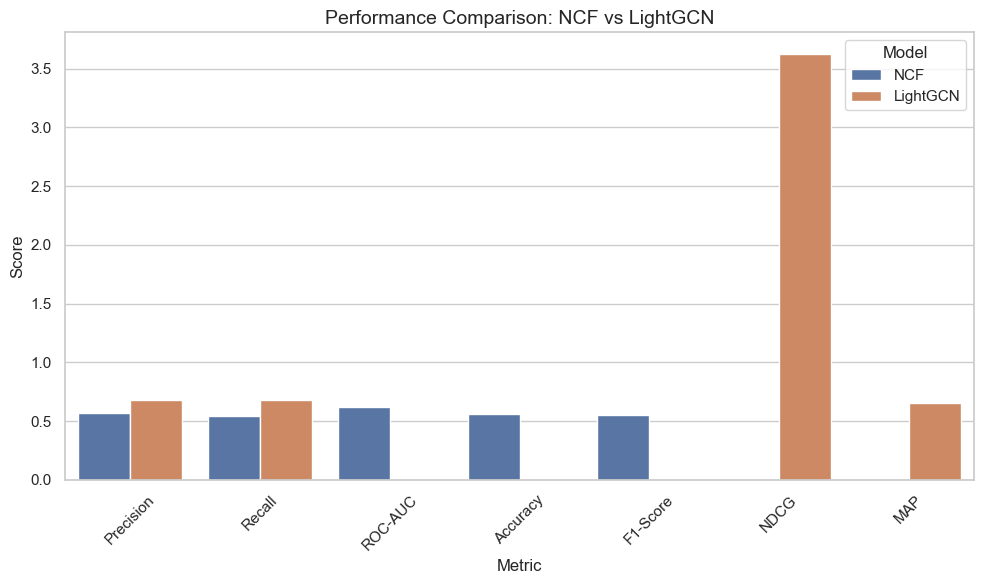

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Performance metrics for NCF and LightGCN
metrics = {
    "Metric": ["Precision", "Recall", "NDCG", "MAP", "ROC-AUC", "Accuracy", "F1-Score"],
    "NCF": [0.5723, 0.5403, None, None, 0.6226, 0.5653, 0.5558],
    "LightGCN": [0.6800, 0.6800, 3.6280, 0.6521, None, None, None]
}

df = pd.DataFrame(metrics)

# Reshape data and drop NAs for plotting
df_melted = df.melt(id_vars="Metric", var_name="Model", value_name="Score").dropna()

# Plot bar chart
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.barplot(x="Metric", y="Score", hue="Model", data=df_melted)
plt.title("Performance Comparison: NCF vs LightGCN", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


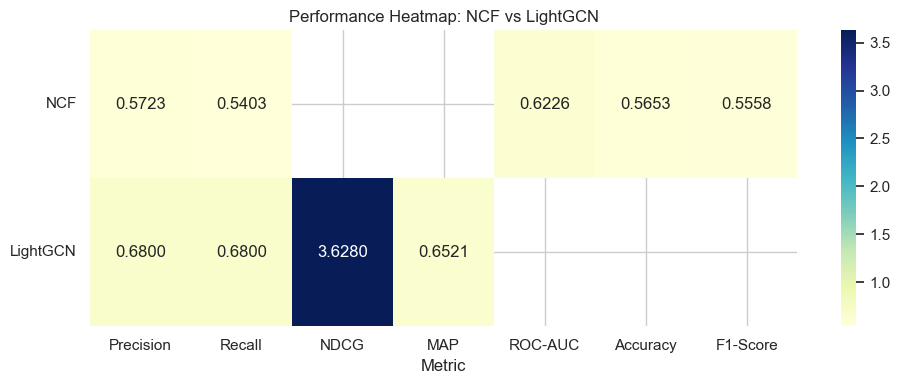

In [12]:
# Reformat DataFrame for heatmap
heatmap_data = df.set_index("Metric").T
heatmap_data = heatmap_data.dropna(axis=1, how='all')

# Plot heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt=".4f", cbar=True)
plt.title("Performance Heatmap: NCF vs LightGCN")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()
